In [14]:
from tokenize import endpats

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
train_df = pd.read_csv('train.csv')

In [16]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


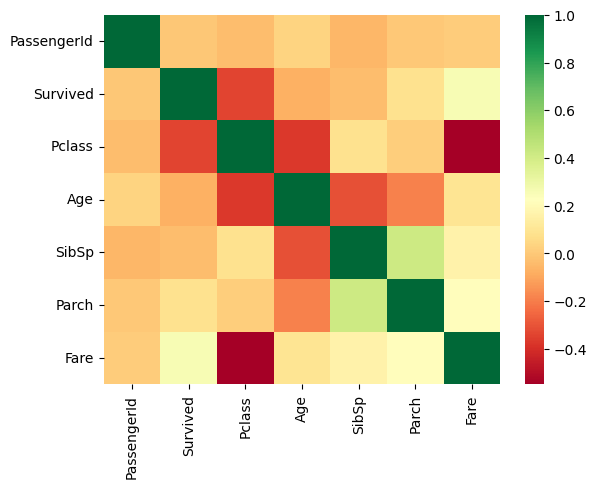

In [23]:
numeric_df = train_df.select_dtypes(include = ['int64','float64'])
sns.heatmap(numeric_df.corr(), cmap='RdYlGn')
plt.show()

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit

In [36]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2)
for train_indx, test_indx in split.split(train_df, train_df[["Survived", "Pclass", "Sex"]]):
    strat_train_set = train_df.loc[train_indx]
    strat_test_set = train_df.loc[test_indx]

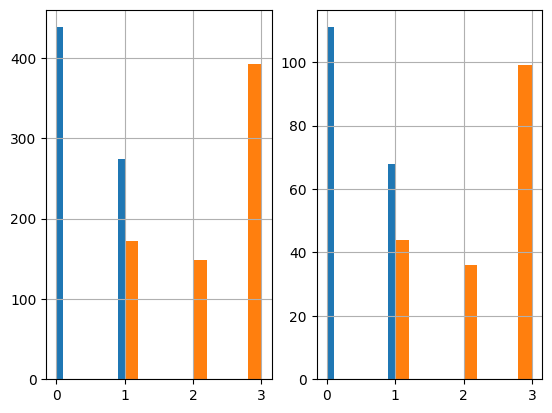

In [39]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

plt.show()

In [41]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 846 to 361
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          565 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        159 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [49]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [50]:
class AgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, *, param=1):
        self.param = param

    def fit(self, X, y=None):
        return self

    def transform(self, X):
       imputer = SimpleImputer(strategy='mean')
       X['Age'] = imputer.fit_transform(X[['Age']])
       return X

In [51]:
#one-hot encoding 'Embarked'(SQC -> 0,1)

In [52]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, *, param=1):
        self.param = param

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()

        col_names = ["S","C","Q","N"]
        for i in range(len(matrix.T)):
            X[col_names[i]] = matrix.T[i]

        matrix = encoder.fit_transform(X[['Sex']]).toarray()

        col_names = ["Male","Female"]
        for i in range(len(matrix.T)):
            X[col_names[i]] = matrix.T[i]

        return X

In [53]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(["Embarked","Name","Ticket","Cabin","Sex","N"], axis=1, errors='ignore')

In [60]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("ageimputer", AgeImputer()),
                     ("featureencoder", FeatureEncoder()),
                     (f"featuredropper", FeatureDropper())])

In [62]:
strat_train_set = pipeline.fit_transform(strat_train_set)

KeyError: "None of [Index(['Embarked'], dtype='object')] are in the [columns]"

In [63]:
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,S,C,Q,Male,Female
846,847,0,3,29.579062,8,2,69.5500,0.0,0.0,1.0,0.0,1.0
843,844,0,3,34.500000,0,0,6.4375,1.0,0.0,0.0,0.0,1.0
338,339,1,3,45.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
762,763,1,3,20.000000,0,0,7.2292,1.0,0.0,0.0,0.0,1.0
802,803,1,1,11.000000,1,2,120.0000,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
217,218,0,2,42.000000,1,0,27.0000,0.0,0.0,1.0,0.0,1.0
432,433,1,2,42.000000,1,0,26.0000,0.0,0.0,1.0,1.0,0.0
539,540,1,1,22.000000,0,2,49.5000,1.0,0.0,0.0,1.0,0.0
661,662,0,3,40.000000,0,0,7.2250,1.0,0.0,0.0,0.0,1.0


In [64]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 846 to 361
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   S            712 non-null    float64
 8   C            712 non-null    float64
 9   Q            712 non-null    float64
 10  Male         712 non-null    float64
 11  Female       712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [65]:
from sklearn.preprocessing import StandardScaler

In [68]:
X = strat_train_set.drop(['Survived'], axis=1)
y = strat_train_set['Survived']

scaler = StandardScaler()

X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [73]:
clf = RandomForestClassifier()
param_grid = [
    { "n_estimators": [10, 100, 200, 500], "max_depth": [None, 5 , 10], "min_samples_split": [2, 3, 4] }
]

grid_search = GridSearchCV(clf, param_grid, cv = 3, scoring = 'accuracy', return_train_score = True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [74]:
final_clf = grid_search.best_estimator_

In [75]:
final_clf

RandomForestClassifier(max_depth=10, min_samples_split=4, n_estimators=500)

In [88]:
strat_test_set = pipeline.fit_transform(strat_test_set)

KeyError: "None of [Index(['Embarked'], dtype='object')] are in the [columns]"

In [89]:
strat_test_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,S,C,Q,Male,Female
746,747,0,3,16.000000,1,1,20.2500,0.0,0.0,1.0,0.0,1.0
57,58,0,3,28.500000,0,0,7.2292,1.0,0.0,0.0,0.0,1.0
304,305,0,3,30.154362,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
714,715,0,2,52.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
710,711,1,1,24.000000,0,0,49.5042,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,1,1,58.000000,0,0,146.5208,1.0,0.0,0.0,1.0,0.0
92,93,0,1,46.000000,1,0,61.1750,0.0,0.0,1.0,0.0,1.0
666,667,0,2,25.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
781,782,1,1,17.000000,1,0,57.0000,0.0,0.0,1.0,1.0,0.0


In [91]:
X_test = strat_test_set.drop(['Survived'], axis=1)
y_test = strat_test_set['Survived']

scaler = StandardScaler()

X_test_data = scaler.fit_transform(X_test)
y_test_data = y_test.to_numpy()

In [92]:
final_clf.score(X_test_data, y_test_data)

0.8212290502793296

In [93]:
final_data = pipeline.fit_transform(train_df)

In [95]:
final_data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,S,C,Q,Male,Female
0,1,0,3,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.0,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.0,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [96]:
X_final = final_data.drop(['Survived'], axis=1)
y_final = final_data['Survived']

scaler = StandardScaler()

X_final_data = scaler.fit_transform(X_final)
y_final_data = y_final.to_numpy()

In [97]:
production_clf = RandomForestClassifier()
param_grid = [
    { "n_estimators": [10, 100, 200, 500], "max_depth": [None, 5 , 10], "min_samples_split": [2, 3, 4] }
]

grid_search = GridSearchCV(production_clf, param_grid, cv = 3, scoring = 'accuracy', return_train_score = True)
grid_search.fit(X_final_data, y_final_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [98]:
prod_final_clf = grid_search.best_estimator_

In [99]:
prod_final_clf

RandomForestClassifier(max_depth=5)

In [100]:
titanic_test_data = pd.read_csv('test.csv')

In [101]:
final_test_data = pipeline.fit_transform(titanic_test_data)

In [102]:
final_test_data

,PassengerId,Pclass,Age,SibSp,Parch,Fare,S,C,Q,Male,Female
0,892,3,34.50000,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,893,3,47.00000,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,894,2,62.00000,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,895,3,27.00000,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,896,3,22.00000,1,1,12.2875,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
414,1306,1,39.00000,0,0,108.9000,1.0,0.0,0.0,1.0,0.0
415,1307,3,38.50000,0,0,7.2500,0.0,0.0,1.0,0.0,1.0
416,1308,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [106]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method='ffill')

scaler = StandardScaler()

X_data_final_test = scaler.fit_transform(X_final_test)

C:\Users\Filip\AppData\Local\Temp\ipykernel_4440\1780821066.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test = X_final_test.fillna(method='ffill')


In [107]:
predictions = prod_final_clf.predict(X_data_final_test)

In [110]:
final_df = pd.DataFrame(titanic_test_data, columns=['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv('predictions.csv', index=False)

In [111]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
